In [12]:
import pandas as pd
import pickle

import sys
sys.path.append('C:\\Users\\Tim\\PycharmProjects\\625.687\src') # your local repo here

path = "C:\\Users\\Tim\\Desktop\\MillionSongSubsetMillionSongSubset_dataframe_test.pkl" # your local data here
big_path = "C:\\Users\\Tim\\Pictures\\MillionSongSubset_dataframe_test_.track_id_segments_timbre.pkl"
df = pickle.load(open(big_path, "rb"))

In [140]:
'''
Vectorize segments_timbre
'''
import collections
import numpy as np
from scipy.stats import entropy

def normalize_segments_timbre(segments_timbre_column):
    """ Find value range for timbre """
    minimum = segments_timbre_column.iloc[0][0][0]
    maximum = segments_timbre_column.iloc[0][0][0]
    for series in segments_timbre_column:
        for vector in series:
            for score in vector:
                if score > maximum:
                    maximum = score
                if score < minimum:
                    minimum = score
    return minimum, maximum

def segments_timbre_distribution(timbre_vector, minimum, maximum):
    """
    Constructs a 32 by 8 histogram; the 32 represents 32 timbre bins
    Goal is to create a single vector which captures timbre range and variety
    """
    # Space out the range [0,1] to 32 equally separated values
    bin_values = np.linspace(minimum, maximum, 32)
    timbre_bins = {}
    for timbre in range(12):
        timbre_bins[timbre] = collections.defaultdict(float)

    # Generate 2-D timbre frequency histogram
    for entry in timbre_vector:  # vector of 12 semitones (A->G#)
        for i in range(12):  # for each tone
            tone_idx = 0
            while entry[i] >= bin_values[tone_idx]:  # find the bin for that tone's value,
                if tone_idx == 31:
                    break
                tone_idx += 1
            timbre_bins[i][tone_idx] += 1  # then save it to tone_bins

    # Now, collapse the 2-D histogram into a 256-length feature vector
    return_vector = []
    histogram = []
    normalization_factor = len(timbre_vector) # normalize, since more entries -> higher values due to length
    for i in range(12):
        histogram_tone = []
        for j in range(32):
            return_vector.append(timbre_bins[i][j] / normalization_factor)
            histogram_tone.append(timbre_bins[i][j] / normalization_factor)
        histogram.append(histogram_tone)
    return return_vector, histogram


def vectorize_segments_timbre_average(timbre_vector, minimum, maximum):
    """
    For each timbre value, generate a sliding window of length 64. Then over those grouped values,
    compute entropy;
    """
    # Iterate over sliding windows of length 64
    num_windows = len(timbre_vector) // 64
    tone_means = collections.defaultdict(list)
    for window_index in range(num_windows + 1):
        i = window_index * 64
        j = (window_index + 1) * 64
        if j > len(timbre_vector):
            j = len(timbre_vector)

        # For each window, collect and group tone values
        tones_vector = collections.defaultdict(list)
        while i < j:
            for tone_idx in range(12):
                tones_vector[tone_idx].append(timbre_vector[i][tone_idx])
            i += 1

        # Compute entropy of tone value over each window for each tone
        for tone in tones_vector.keys():
            window_mean = np.mean(timbre_vector[window_index])  # is entropy what we want to measure here?
            tone_means[tone].append(window_mean)

    # Separate entropy values per tone into percentiles
    tone_percentiles = collections.defaultdict(list)
    percentiles = np.linspace(0, 1, 21)
    for tone in tone_means.keys():
        for p in percentiles:
            p = p * 100
            val = np.percentile(tone_means[tone], p)
            tone_percentiles[tone].append(val)

    # Now, collapse the 2-D histogram into a 256-length feature vector
    return_vector = [0, 0, 0, 0, ]  # four empty values; use for other metadata?
    for i in range(12):
        for j in range(21):
            return_vector.append(tone_percentiles[i][j])
    for i in range(len(return_vector)):
        if not isinstance(return_vector[i], float) or np.isnan(return_vector[i]):
            pass
    return return_vector

In [141]:
minimum, maximum = normalize_segments_timbre(subdf["segments_timbre"])
vec, hist = segments_timbre_distribution(subdf["segments_timbre"][0], minimum, maximum)

In [28]:
subdf = df

minimum, maximum = normalize_segments_timbre(subdf["segments_timbre"])
timbre_features = [vectorize_segments_timbre_average(x, minimum, maximum) + 
                   segments_timbre_distribution(x, minimum, maximum)
                   for x in subdf["segments_timbre"]]
subdf["timbre_features"] = timbre_features

In [17]:
import Metrics
import numpy as np

mf = Metrics.Metric() # metric factory
metrics_df = []

# Compute a square matrix of scores (every song against every song)
for index1, row1 in subdf.iterrows():
    metric_scores = []
    for index2, row2 in subdf.iterrows():
        score = mf.L_2_norm(row1["timbre_features"], row2["timbre_features"])
        metric_scores.append(score)
    metrics_df.append(metric_scores)
    
metrics_df = np.asarray(metrics_df)

In [18]:
from msd_utils import compute_metric_matrix

l1_dmatrix = compute_metric_matrix(subdf, "timbre_features", "L_1_norm")
l2_dmatrix = compute_metric_matrix(subdf, "timbre_features", "L_2_norm")
linf_dmatrix = compute_metric_matrix(subdf, "timbre_features", "L_inf_norm")
cosine_dmatrix = compute_metric_matrix(subdf, "timbre_features", "cosine_similarity")

dmatrices = [
    l1_dmatrix,
    l2_dmatrix,
    linf_dmatrix,
    cosine_dmatrix
]

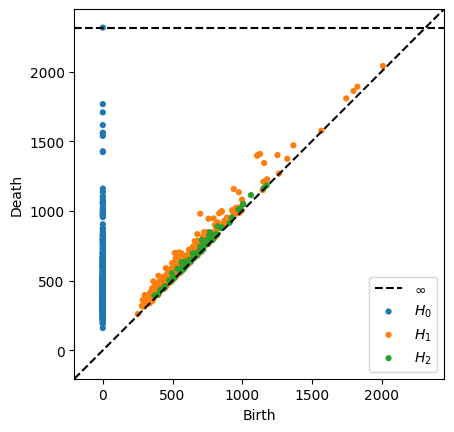

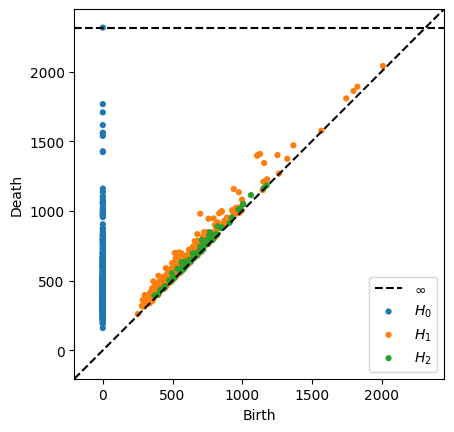

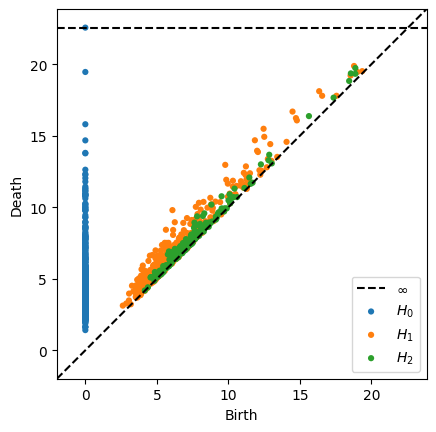

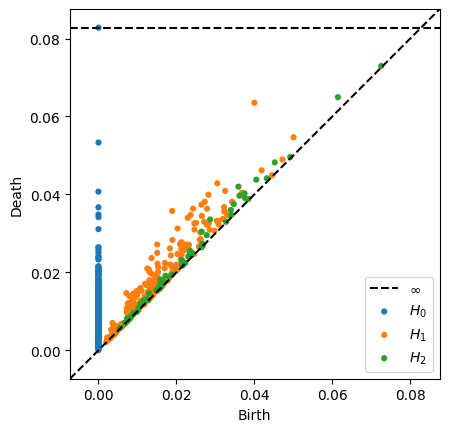

In [19]:
from ripser import ripser
from persim import plot_diagrams
import numpy as np

for matrix in dmatrices:
    matrix = np.asarray(matrix)
    res = ripser(matrix, distance_matrix=True, maxdim=2)
    plot_diagrams(res['dgms'], show=True)

In [ ]:
radius = 2000 # picked a value after looking at the L2 outputs

# Group together elements which, for a given radius, have metric values less than some radius
# Using matrix indices to save groups; indices should stil align to position in subdf 

elements = set()
for i in range(len(metrics_df)):
    ball_centered_around_i = set()
    for j in range(len(metrics_df)):
        if metrics_df[i][j] < radius:
            ball_centered_around_i.add(j)
    ball = tuple(sorted(ball_centered_around_i))
    elements.add(ball)

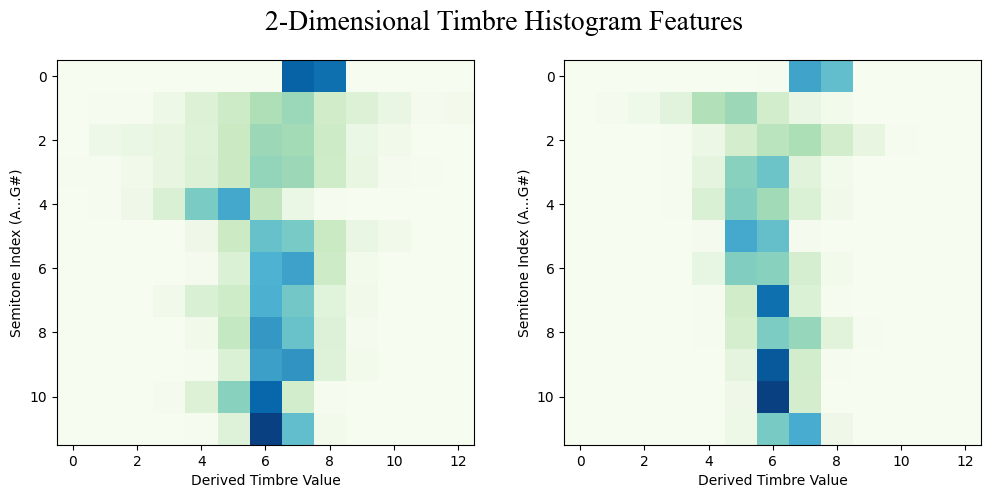

In [214]:
import matplotlib.pyplot as plt
import numpy as np

vec, hist = segments_timbre_distribution(subdf["segments_timbre"][0], minimum, maximum)
vec2, hist2 = segments_timbre_distribution(subdf["segments_timbre"][255], minimum, maximum)
hist = [x[10:23] for x in hist]
hist2 = [x[10:23] for x in hist2]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('2-Dimensional Timbre Histogram Features', font="Times New Roman", size="20")

plt.subplot(1, 2, 1)  # row 1, column 2, count 1
plt.ylabel("Semitone Index (A...G#)")
plt.xlabel("Derived Timbre Value")
plt.imshow(hist, cmap='GnBu', interpolation='nearest')

plt.subplot(1, 2, 2)
plt.imshow(hist2, cmap='GnBu', interpolation='nearest')
plt.ylabel("Semitone Index (A...G#)")
plt.xlabel("Derived Timbre Value")
plt.show()

In [27]:
.columns

Index(['segments_timbre', 'timbre_features'], dtype='object')

In [22]:
import pandas as pd
import pickle

import sys
sys.path.append('C:\\Users\\Tim\\PycharmProjects\\625.687\src') # your local repo here

metadata = "C:\\Users\\Tim\\Pictures\\MillionSongSubset_dataframe_test_.track_id_year_genre_song_hotttnesss_artist_terms.pkl"
metadata_df = pickle.load(open(metadata, "rb"))

In [32]:
test = subdf.merge(metadata_df, left_on="track_id", right_on="track_id")

In [34]:
year_test = test[test["year"] != 0]

In [132]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

clf = RandomForestRegressor(n_estimators=500, )
train_x, test_x, train_y, test_y = train_test_split(year_test["timbre_features"], year_test["year"],
                                                   test_size=0.2, random_state=666)

train_x = [np.asarray(x) for x in train_x]
train_y = [np.asarray(x) for x in train_y]
test_x = [np.asarray(x) for x in test_x]
test_y = [np.asarray(x) for x in test_y]

y_score = clf.fit(train_x, train_y).predict(test_x)

diffs = [abs(y_score[i] - test_y[i]) for i in range(len(y_score))]

Mean: 7.872120000000013
Stdv: 8.376190804034973
Mode: 0.07600000000002183
Quantiles: [ 0.076  2.363  4.998  9.246 37.162]


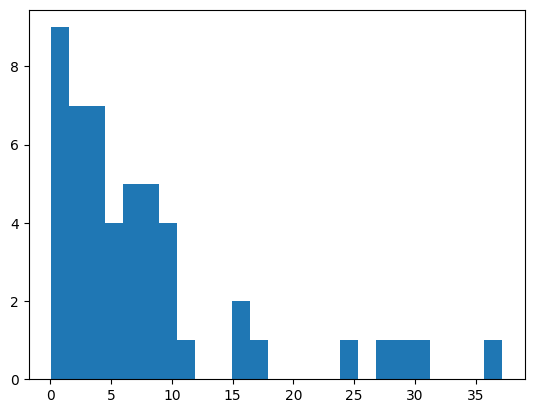

In [133]:
import matplotlib.pyplot as plt

print("Mean:", np.mean(diffs))
print("Stdv:", np.std(diffs))
print("Mode:", max(set(diffs), key=diffs.count))
print("Quantiles:", np.quantile(diffs, [0.0, 0.25, 0.5, 0.75, 1.]))

plt.hist(diffs, bins=25)
plt.show()

Mean: 7.770280000000002
Stdv: 8.371852220482635
Quantiles: [ 0.46    2.3505  5.182   8.597  37.77  ]


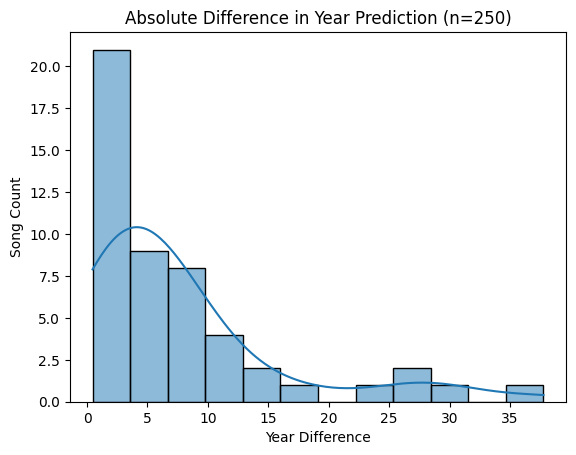

In [128]:
import seaborn as sns
plt.title("Absolute Difference in Year Prediction (n=250)")
plt.xlabel("Year Difference")
plt.ylabel("Song Count")
sns.histplot(diffs, kde=True)

print("Mean:", np.mean(diffs))
print("Stdv:", np.std(diffs))
print("Quantiles:", np.quantile(diffs, [0.0, 0.25, 0.5, 0.75, 1.]))

plt.show()

In [119]:
import pandas as pd

hotness_df = pd.DataFrame(
    [row for index, row in test.iterrows() if not np.isnan(row["song_hotttnesss"])]
)

Mean: 0.19452506093384395
Stdv: 0.1315699870333689
Quantiles: [0.01173517 0.0713476  0.17010735 0.29515784 0.46131981]


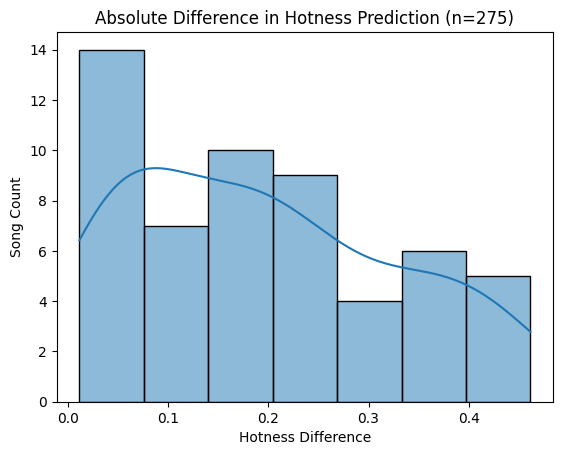

In [131]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

clf = RandomForestRegressor(n_estimators=500, )
train_x, test_x, train_y, test_y = train_test_split(hotness_df["timbre_features"], hotness_df["song_hotttnesss"],
                                                   test_size=0.2, random_state=666)

train_x = [np.asarray(x) for x in train_x]
train_y = [np.asarray(x) for x in train_y]
test_x = [np.asarray(x) for x in test_x]
test_y = [np.asarray(x) for x in test_y]

y_score = clf.fit(train_x, train_y).predict(test_x)

diffs = [abs(y_score[i] - test_y[i]) for i in range(len(y_score))]
print("Mean:", np.mean(diffs))
print("Stdv:", np.std(diffs))
print("Quantiles:", np.quantile(diffs, [0.0, 0.25, 0.5, 0.75, 1.]))


import seaborn as sns
plt.title("Absolute Difference in Hotness Prediction (n=275)")
plt.xlabel("Hotness Difference")
plt.ylabel("Song Count")
sns.histplot(diffs, kde=True)
plt.show()

,segments_timbre,track_id,timbre_features
0,"[[0.0, 171.13, 9.469, -28.48, 57.491, -50.067,...",b'TRAAAAW128F429D538',"[0, 0, 0, 0, -37.57149999999999, -36.744437500..."
1,"[[0.0, 171.13, 9.469, -28.48, 57.491, -50.067,...",b'TRAAABD128F429CF47',"[0, 0, 0, 0, -0.7624999999999988, -0.521866666..."
2,"[[0.0, 171.124, 9.459, -28.489, 57.482, -50.06...",b'TRAAADZ128F9348C2E',"[0, 0, 0, 0, -9.826083333333337, -4.2545500000..."
3,"[[24.937, 37.465, 177.22, -216.443, 56.3, 202....",b'TRAAAEF128F4273421',"[0, 0, 0, 0, 1.3936666666666657, 4.58486666666..."
4,"[[0.089, 169.621, 5.435, -30.061, 54.144, -50....",b'TRAAAFD128F92F423A',"[0, 0, 0, 0, 1.2993333333333348, 1.65125000000..."
...,...,...,...
495,"[[0.02, 170.773, 8.687, -28.991, 56.786, -50.2...",b'TRABQEB128F4274D24',"[0, 0, 0, 0, -8.629083333333332, -7.5766791666..."
496,"[[0.0, 171.13, 9.469, -28.48, 57.491, -50.067,...",b'TRABQEW128F93214A8',"[0, 0, 0, 0, -3.9194999999999998, 3.3976250000..."
497,"[[0.0, 171.13, 9.469, -28.48, 57.491, -50.067,...",b'TRABQFJ12903CB6C29',"[0, 0, 0, 0, -0.7960833333333349, -0.102750000..."
498,"[[0.004, 171.055, 9.354, -28.587, 57.387, -50....",b'TRABQGT128F42566D3',"[0, 0, 0, 0, 1.9659166666666685, 3.13764583333..."
